In [1]:
from utils.load_results import *
from utils.plot_helpers import *

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
datasets = ['(3,4)', '(3,8)', '(3,16)', '(4,4)', '(4,8)', '(5,4)']
n_values = [4, 8, 16, 4, 8, 4]
n_attributes = [3, 3, 3, 4, 4, 5]
n_epochs = 300
n_runs = 5
n_datasets = len(datasets)
paths = ['results/' + d + '_game_size_10_vsf_3' for d in datasets]

In [3]:
context_unaware = False # whether original or context_unaware simulations are evaluated
length_cost = True
if context_unaware:
    setting = 'context_unaware'
elif length_cost:
    setting = 'length_cost_001'
else:
    setting = 'standard'

### Todo: modify for length cost

## training

In [4]:
result_dict = {'train_acc': [], 'val_acc': [], 'test_acc': [], 'train_loss': [], 'val_loss': [], 'test_loss': [], 'train_message_length': [], 'val_message_length': []}
    
for path_idx, path in enumerate(paths):

    train_accs = []
    val_accs = []
    test_accs = []
    train_losses = []
    val_losses = []
    test_loss = []
    train_message_lengths = []
    val_message_lengths = []

    for run in range(n_runs):
        
        length_cost_path = path + '/length_cost_001/' +  str(run) + '/'
        
        data = pickle.load(open(length_cost_path + 'loss_and_metrics.pkl', 'rb'))
        # accuracies
        lists = sorted(data['metrics_train0'].items())
        _, train_acc = zip(*lists)
        train_accs.append(train_acc)
        lists = sorted(data['metrics_test0'].items()) 
        _, val_acc = zip(*lists)
        val_accs.append(val_acc)
        test_accs.append(data['final_test_acc'])
        
        # losses
        lists = sorted(data['loss_train'].items())
        _, train_loss = zip(*lists)
        train_losses.append(train_loss)
        lists = sorted(data['loss_test'].items())
        _, val_loss = zip(*lists)
        val_losses.append(val_loss)
        test_loss.append(data['final_test_loss'])
        
        # message lengths
        lists = sorted(data['metrics_train1'].items())
        _, train_message_length = zip(*lists)
        train_message_lengths.append(train_message_length)
        lists = sorted(data['metrics_test1'].items()) 
        _, val_message_length = zip(*lists)
        val_message_lengths.append(val_message_length)

    result_dict['train_acc'].append(train_accs)
    result_dict['val_acc'].append(val_accs)
    result_dict['test_acc'].append(test_accs)
    result_dict['train_loss'].append(train_losses)
    result_dict['val_loss'].append(val_losses)
    result_dict['test_loss'].append(test_loss)
    result_dict['train_message_length'].append(train_message_lengths)
    result_dict['val_message_length'].append(val_message_lengths)

for key in result_dict.keys():
    result_dict[key] = np.array(result_dict[key])

all_accuracies = result_dict

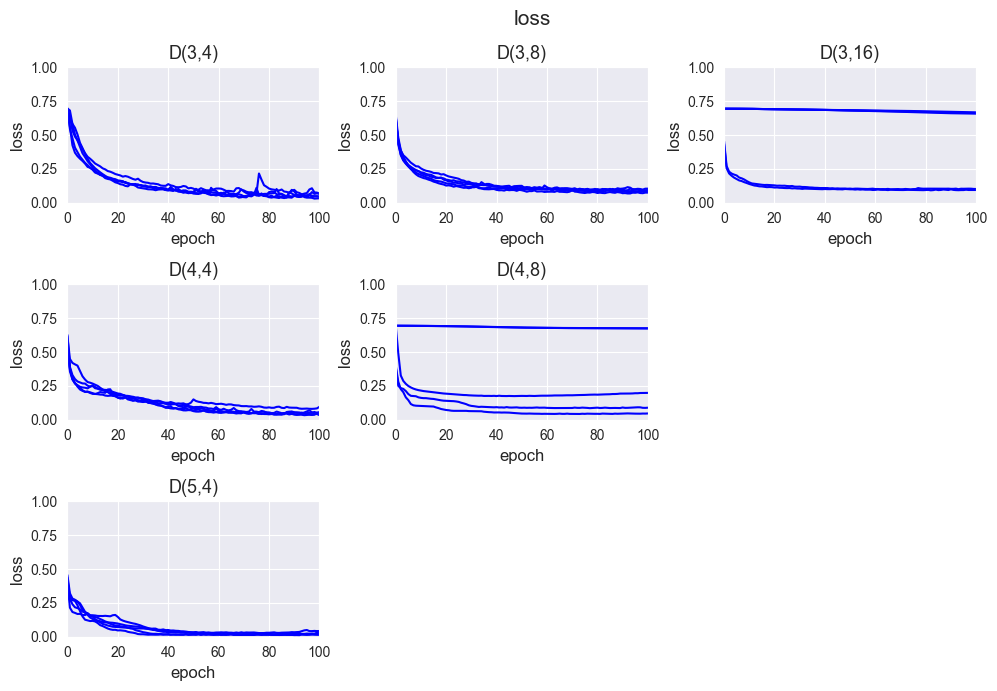

In [5]:
plot_training_trajectory(all_accuracies['train_loss'], all_accuracies['val_loss'], ylim=(0, 1), xlim=(0, 100), steps=(1, 1), #message_length_train=all_accuracies['train_message_length'], message_length_val=all_accuracies['val_message_length'], 
train_only=True, loss_plot=True, n_epochs=300)

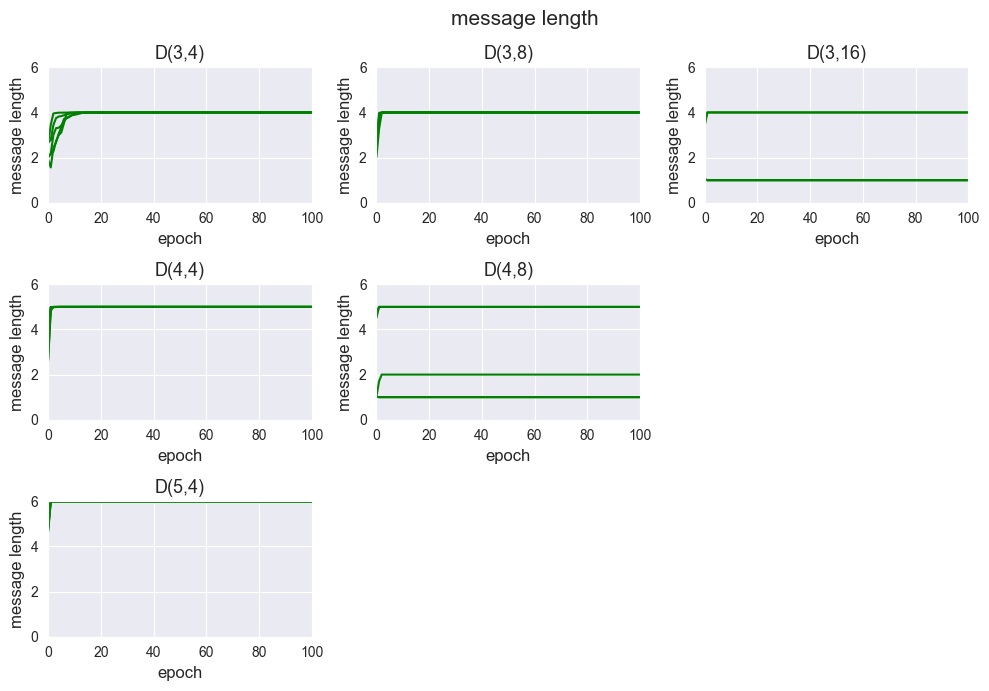

In [7]:
plot_training_trajectory(results_train=None, results_val=None, ylim=(0, 6), xlim=(0, 100), steps=(1, 1), message_length_train=all_accuracies['train_message_length'], 
train_only=True, message_length_plot=True, n_epochs=300)

## final accuracies 

In [6]:
accuracies = [all_accuracies['train_acc'], all_accuracies['val_acc']]

In [7]:
# get accuracy means and sds for table representation
final_accuracies_train = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies['train_acc'][i][run][-1])
    final_accuracies_train[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_train

{'(3,4)': (0.993, 0.003),
 '(3,8)': (0.984, 0.003),
 '(3,16)': (0.735, 0.19),
 '(4,4)': (0.992, 0.003),
 '(4,8)': (0.799, 0.195),
 '(5,4)': (0.993, 0.003)}

In [8]:
final_accuracies_val = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies['val_acc'][i][run][-1])
    final_accuracies_val[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_val

{'(3,4)': (0.982, 0.007),
 '(3,8)': (0.977, 0.003),
 '(3,16)': (0.721, 0.2),
 '(4,4)': (0.989, 0.005),
 '(4,8)': (0.775, 0.195),
 '(5,4)': (0.991, 0.005)}

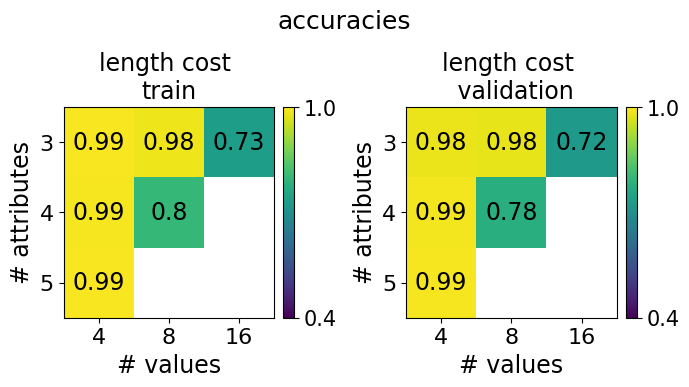

In [9]:
plot_heatmap(accuracies, 'mean', plot_dims=(1,2), ylims=(0.4, 1.0), figsize=(7, 3.5), suptitle='accuracies', 
             fontsize=17, titles=('length cost \ntrain', 'length cost \n validation'))

## entropy scores 
### context-aware

In [10]:
entropy_scores = load_entropies(paths, length_cost=0.001)
entropies = [entropy_scores['NMI'], entropy_scores['effectiveness'], entropy_scores['consistency']]

/Users/kkobrock/Projects/phdproject1/emergent-abstractions/utils/load_results.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_dict[key] = np.array(result_dict[key])


In [11]:
entropy_dict = {}
for i, score in enumerate(list(entropy_scores.keys())[:3]):
    results = entropies[i]
    mean = np.nanmean(results, axis=-1)
    sd = np.std(results, axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict[d + score] = (round(mean[idx], 3), round(sd[idx], 3))
entropy_dict


{'(3,4)NMI': (0.9, 0.011),
 '(3,8)NMI': (0.887, 0.014),
 '(3,16)NMI': (0.309, 0.378),
 '(4,4)NMI': (0.91, 0.01),
 '(4,8)NMI': (0.411, 0.371),
 '(5,4)NMI': (0.887, 0.021),
 '(3,4)effectiveness': (0.917, 0.006),
 '(3,8)effectiveness': (0.86, 0.024),
 '(3,16)effectiveness': (0.281, 0.344),
 '(4,4)effectiveness': (0.941, 0.016),
 '(4,8)effectiveness': (0.38, 0.369),
 '(5,4)effectiveness': (0.922, 0.018),
 '(3,4)consistency': (0.884, 0.022),
 '(3,8)consistency': (0.916, 0.008),
 '(3,16)consistency': (0.859, nan),
 '(4,4)consistency': (0.881, 0.009),
 '(4,8)consistency': (0.809, nan),
 '(5,4)consistency': (0.855, 0.026)}

In [12]:
# from generic to specific
entropies_hierarchical = [entropy_scores['NMI_hierarchical'], entropy_scores['effectiveness_hierarchical'], entropy_scores['consistency_context_dep']]
entropy_dict_context_dep = {}
for i, score in enumerate(list(entropy_scores.keys())[3:6]):
    results = entropies_hierarchical[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])
entropy_dict_context_dep


{'(3,4)NMI_hierarchical': array([0.98051479, 0.92783159, 0.90567635]),
 '(3,8)NMI_hierarchical': array([0.91818261, 0.90967207, 0.88124118]),
 '(3,16)NMI_hierarchical': array([0.31617005, 0.32326428, 0.30535371]),
 '(4,4)NMI_hierarchical': array([0.91942715, 0.94327311, 0.9258402 , 0.91062988]),
 '(4,8)NMI_hierarchical': array([0.48178083, 0.45071996, 0.43039988, 0.41142334]),
 '(5,4)NMI_hierarchical': array([0.90618664, 0.9267642 , 0.92618489, 0.90532101, 0.88602194]),
 '(3,4)effectiveness_hierarchical': array([1.        , 0.96403077, 0.963296  ]),
 '(3,8)effectiveness_hierarchical': array([0.91917966, 0.89748798, 0.85785478]),
 '(3,16)effectiveness_hierarchical': array([0.3441788 , 0.30606784, 0.27649323]),
 '(4,4)effectiveness_hierarchical': array([1.        , 0.99022604, 0.98253417, 0.97487059]),
 '(4,8)effectiveness_hierarchical': array([0.48862069, 0.43384357, 0.40870328, 0.38483805]),
 '(5,4)effectiveness_hierarchical': array([0.98764567, 0.98843263, 0.98278741, 0.96945905, 0.96

In [13]:
# from coarse to fine context
entropies_context_dep = [entropy_scores['NMI_context_dep'], entropy_scores['effectiveness_context_dep'], entropy_scores['consistency_context_dep']]
entropy_dict_context_dep = {}
for i, score in enumerate(list(entropy_scores.keys())[6:9]):
    results = entropies_context_dep[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])
entropy_dict_context_dep


{'(3,4)NMI_context_dep': array([0.89789428, 0.93819145, 0.96887718]),
 '(3,8)NMI_context_dep': array([0.90166218, 0.90380691, 0.91585318]),
 '(3,16)NMI_context_dep': array([0.32297682, 0.3213958 , 0.32009776]),
 '(4,4)NMI_context_dep': array([0.91894025, 0.92873646, 0.94453818, 0.96990039]),
 '(4,8)NMI_context_dep': array([0.42548565, 0.42739047, 0.43468323, 0.44314906]),
 '(5,4)NMI_context_dep': array([0.89694779, 0.90975047, 0.92668072, 0.94229012, 0.95990414]),
 '(3,4)effectiveness_context_dep': array([0.88743181, 0.94044951, 0.9812431 ]),
 '(3,8)effectiveness_context_dep': array([0.86047812, 0.86851582, 0.87289099]),
 '(3,16)effectiveness_context_dep': array([0.28786185, 0.28920486, 0.27945577]),
 '(4,4)effectiveness_context_dep': array([0.93093164, 0.94300379, 0.96458979, 0.99043507]),
 '(4,8)effectiveness_context_dep': array([0.38205195, 0.38666076, 0.39787898, 0.39725493]),
 '(5,4)effectiveness_context_dep': array([0.90077587, 0.92182993, 0.94923382, 0.97109942, 0.99020728]),
 '

In [14]:
# from generic&coarse to specific&fine
entropies_concept_x_context = [entropy_scores['NMI_concept_x_context'], entropy_scores['effectiveness_concept_x_context'], entropy_scores['consistency_concept_x_context']]
entropy_dict_conc_x_cont = {}
for i, score in enumerate(list(entropy_scores.keys())[9:]):
    results = entropies_context_dep[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_conc_x_cont[d + score] = mean[idx] #(mean[idx], sd[idx])
entropy_dict_conc_x_cont

{'(3,4)NMI_concept_x_context': array([0.89789428, 0.93819145, 0.96887718]),
 '(3,8)NMI_concept_x_context': array([0.90166218, 0.90380691, 0.91585318]),
 '(3,16)NMI_concept_x_context': array([0.32297682, 0.3213958 , 0.32009776]),
 '(4,4)NMI_concept_x_context': array([0.91894025, 0.92873646, 0.94453818, 0.96990039]),
 '(4,8)NMI_concept_x_context': array([0.42548565, 0.42739047, 0.43468323, 0.44314906]),
 '(5,4)NMI_concept_x_context': array([0.89694779, 0.90975047, 0.92668072, 0.94229012, 0.95990414]),
 '(3,4)effectiveness_concept_x_context': array([0.88743181, 0.94044951, 0.9812431 ]),
 '(3,8)effectiveness_concept_x_context': array([0.86047812, 0.86851582, 0.87289099]),
 '(3,16)effectiveness_concept_x_context': array([0.28786185, 0.28920486, 0.27945577]),
 '(4,4)effectiveness_concept_x_context': array([0.93093164, 0.94300379, 0.96458979, 0.99043507]),
 '(4,8)effectiveness_concept_x_context': array([0.38205195, 0.38666076, 0.39787898, 0.39725493]),
 '(5,4)effectiveness_concept_x_context':

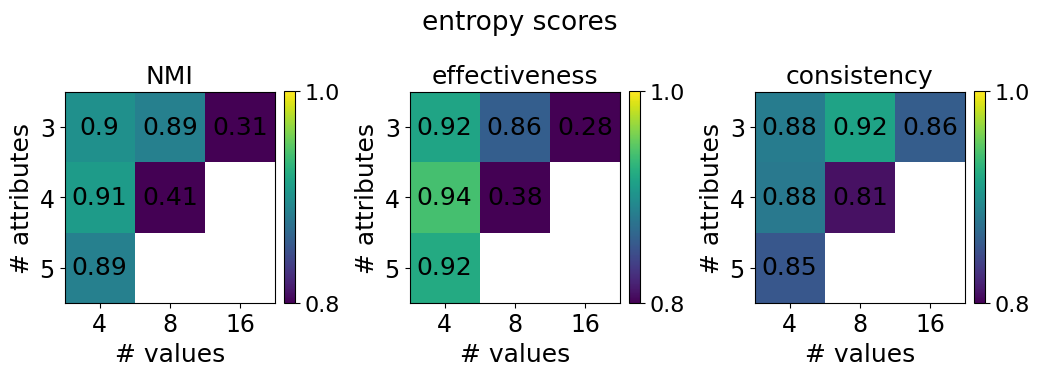

In [15]:
plot_heatmap(entropies, 'mean', plot_dims=(1,3), ylims=(0.8, 1.0), figsize=(10.5, 3.5), 
             titles = ('NMI', 'effectiveness', 'consistency'), suptitle='entropy scores')

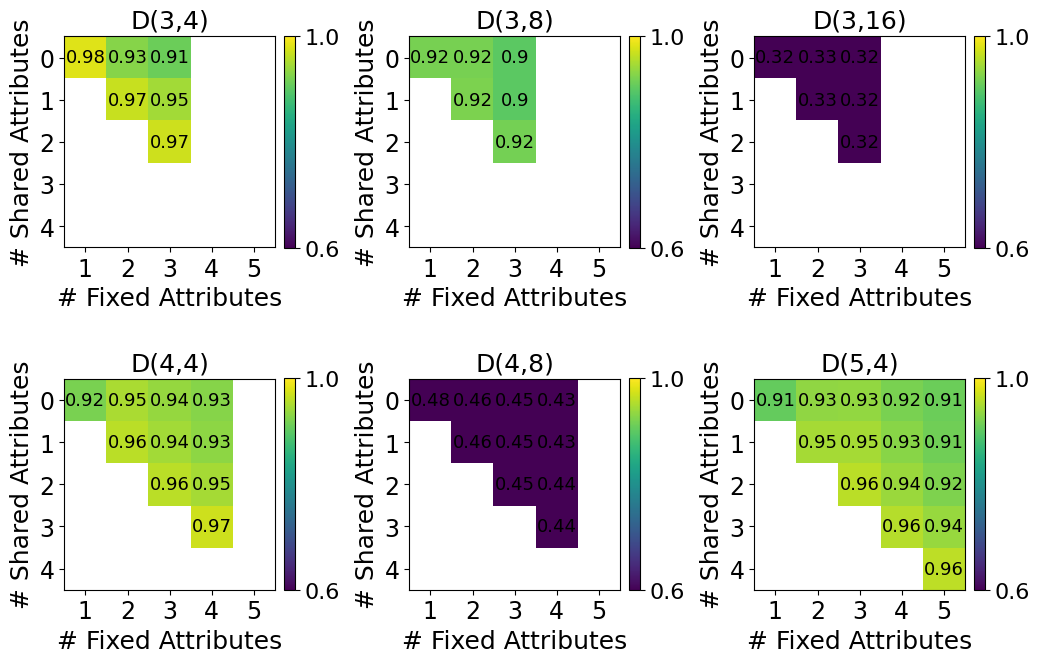

In [17]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='NMI', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), inner_fontsize_fctr=-5)

In [18]:
data_list, run_list, level_list = [], [], []
NMI_hierarchical, effectiveness_hierarchical, consistency_hierarchical = [], [], []

for d, data in enumerate(datasets):
    for run in range(5):
        
        scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
                effectiveness_hierarchical.append(scores['effectiveness_hierarchical'][l])
                consistency_hierarchical.append(scores['consistency_hierarchical'][l])
            except: 
                NMI_hierarchical.append(np.nan)
                effectiveness_hierarchical.append(np.nan)
                consistency_hierarchical.append(np.nan)

entropy_dict_hierarchical = {'data': data_list, 'level': level_list, 'run': run_list, 'NI': NMI_hierarchical, 
                             'effectiveness': effectiveness_hierarchical, 'consistency': consistency_hierarchical}


In [19]:
all_hierarchical = {}
all_hierarchical['metric'] = ['NI'] * 150 + ['effectiveness'] * 150 + ['consistency'] * 150 # change to 25 for one dataset
all_hierarchical['value'] = (entropy_dict_hierarchical['NI'] + 
                             entropy_dict_hierarchical['effectiveness'] + 
                             entropy_dict_hierarchical['consistency'])
all_hierarchical['level'] = entropy_dict_hierarchical['level'] * 3

/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


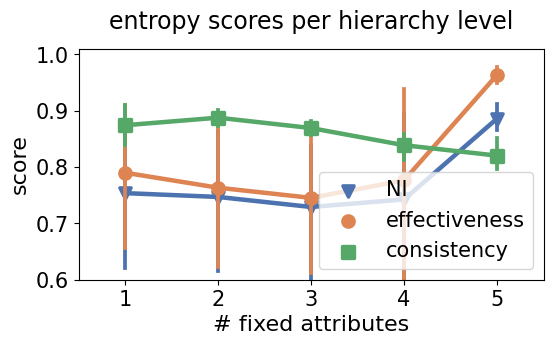

In [20]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_hierarchical, hue='metric', 
                   markers=['v', 'o', 's'], palette='deep', scale=1.2)
plt.ylabel('score', fontsize=16)
plt.title('entropy scores per hierarchy level', fontsize=17, y=1.05)
plt.ylim([0.6,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5])
plt.yticks(ticks=[0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('# fixed attributes', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.show()

In [21]:
data_list, run_list, level_list = [], [], []
NMI_context_dep, effectiveness_context_dep, consistency_context_dep = [], [], []

for d, data in enumerate(datasets):
    for run in range(5):
        
        scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_context_dep.append(scores['normalized_mutual_info_context_dep'][l])
                effectiveness_context_dep.append(scores['effectiveness_context_dep'][l])
                consistency_context_dep.append(scores['consistency_context_dep'][l])
            except: 
                NMI_context_dep.append(np.nan)
                effectiveness_context_dep.append(np.nan)
                consistency_context_dep.append(np.nan)

entropy_dict_context_dep = {'data': data_list, 'level': level_list, 'run': run_list, 'NMI': NMI_context_dep, 
                             'effectiveness': effectiveness_context_dep, 'consistency': consistency_context_dep}


In [22]:
all_context_dep = {}
all_context_dep['metric'] = ['NMI'] * 150 #+ ['effectiveness'] * 150 + ['consistency'] * 150
all_context_dep['value'] = (entropy_dict_context_dep['NMI']# + 
                           #  entropy_dict_context_dep['effectiveness'] + 
                            # entropy_dict_context_dep['consistency']
                            )
all_context_dep['level'] = entropy_dict_context_dep['level'] #* 3

/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


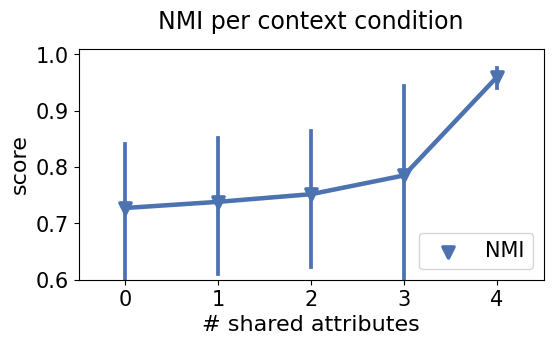

In [23]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_context_dep, hue='metric', 
                   markers=['v', 'o', 's'], palette='deep', scale=1.2)
plt.ylabel('score', fontsize=16)
plt.title('NMI per context condition', fontsize=17, y=1.05)
plt.ylim([0.6,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[0,1,2,3,4])
plt.yticks(ticks=[0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('# shared attributes', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.show()

## message length and symbol redundancy

In [24]:
ml_dict = {'level': [], 'data set': [], 'run': [], 'message length': []}
for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        # if evaluated after training from interaction this is an array showing the message length
        # per level of concreteness (most abstract --> most concrete)
        ml_hierarchical = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_hierarchical.pkl', 'rb'))
        
        # if evaluated with the callback throughout training, you get an array for each epoch
        if isinstance(ml_hierarchical, dict): 
            ml_hierarchical = ml_hierarchical['message_length_train'][n_epochs]
            
        for level in range(5):
            
            ml_dict['level'].append(level)
            ml_dict['run'].append(run)
            ml_dict['data set'].append(dataset)
            try: 
                ml_dict['message length'].append(ml_hierarchical[level])
            except: 
                ml_dict['message length'].append(np.NaN)

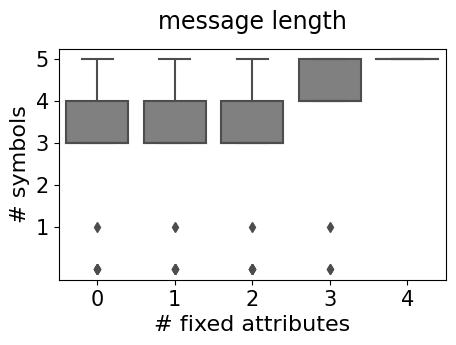

In [25]:
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='message length', data=ml_dict, color='gray')
plt.xticks(fontsize=15)
plt.yticks(ticks=[1,2,3,4,5], labels=[1,2,3,4,5], fontsize=15)
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('# symbols', fontsize=16)
plt.title('message length', fontsize=17, y=1.05)
plt.show()

In [26]:
symbol_redundancy_dict = {'level': [], 'data set': [], 'run': [], 'symbol frequency': []}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        scores = pickle.load(open(paths[d]  + '/' + setting + '/' + str(run) + '/symbol_redundancy.pkl', 'rb'))
            
        for level in range(5):
            
            symbol_redundancy_dict['level'].append(level)
            symbol_redundancy_dict['run'].append(run)
            symbol_redundancy_dict['data set'].append(dataset)
            try: 
                symbol_redundancy_dict['symbol frequency'].append(scores['symbol_redundancy'][level])
            except: 
                symbol_redundancy_dict['symbol frequency'].append(np.NaN)

FileNotFoundError: [Errno 2] No such file or directory: 'results/(3,16)_game_size_10_vsf_3/length_cost_001/2/symbol_redundancy.pkl'

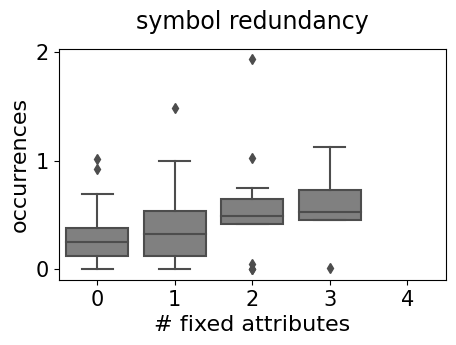

In [7]:
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='symbol frequency', data=symbol_redundancy_dict, color='gray')
plt.xticks(ticks=[0,1,2,3,4], labels=[0,1,2,3,4], fontsize=15)
plt.yticks(ticks=[0, 1, 2], fontsize=15)
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('occurrences', fontsize=16)
plt.title('symbol redundancy', fontsize=17, y=1.05)
plt.show()

## compositionality

In [36]:
context_unaware = True
if context_unaware:
    setting = 'context_unaware'
else:
    setting = 'standard'

In [37]:
topsim, posdis, bosdis = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))
topsim_specific, posdis_specific, bosdis_specific = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        topsim_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        topsim[d, run] = topsim_score['topsim_train']
        posdis[d, run] = disent_score['posdis']
        bosdis[d, run] = disent_score['bosdis']
        topsim_specific[d, run] = topsim_score['topsim_specific_train']
        posdis_specific[d, run] = disent_score['posdis_specific']
        bosdis_specific[d, run] = disent_score['bosdis_specific']

In [38]:
for i, d in enumerate(datasets):
    print(d, "topsim:", round(np.mean(topsim[i]), 3), "sd", round(np.std(topsim[i]), 2))

(3,4) topsim: 0.46 sd 0.07
(3,8) topsim: 0.339 sd 0.03
(3,16) topsim: 0.287 sd 0.04
(4,4) topsim: 0.539 sd 0.02
(4,8) topsim: 0.336 sd 0.05
(5,4) topsim: 0.455 sd 0.03


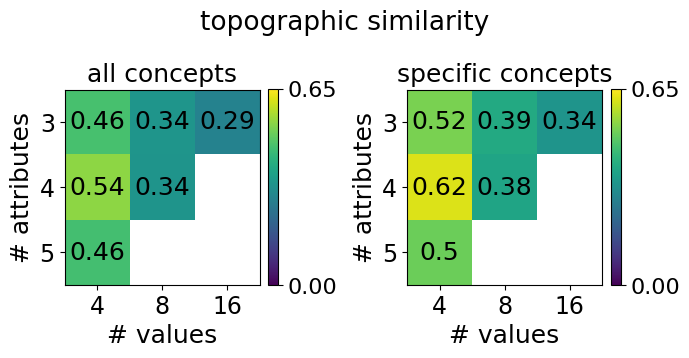

In [39]:
plot_heatmap([topsim, topsim_specific], 'mean', plot_dims=(1,2), ylims=[0.0,0.65], figsize=(7,3.5), 
             titles=['all concepts', 'specific concepts'], suptitle='topographic similarity', suptitle_position=1.)

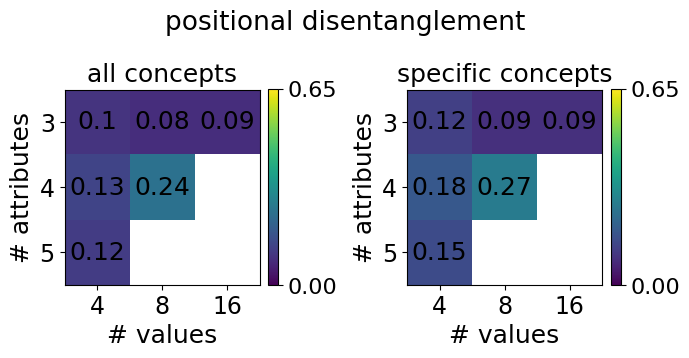

In [33]:
plot_heatmap([posdis, posdis_specific], 'mean', plot_dims=(1,2), ylims=[0.0,0.65], figsize=(7,3.5),
             titles=['all concepts', 'specific concepts'], suptitle='positional disentanglement', suptitle_position=1.)

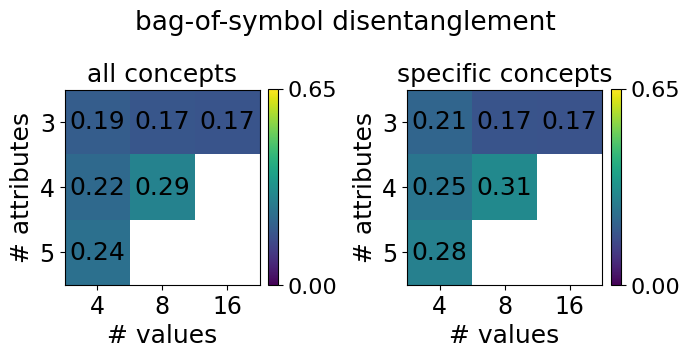

In [34]:
plot_heatmap([bosdis, bosdis_specific], 'mean', plot_dims=(1,2), ylims=[0.0,0.65], figsize=(7,3.5),
             titles=['all concepts', 'specific concepts'], suptitle='bag-of-symbol disentanglement', suptitle_position=1.)

In [35]:
# compositionality scores for each data set

compositionality_scores = {'dataset':[], 'run':[], 'metric':[], 'data':[], 'score':[]}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        topsim = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        
        for metric in ['topsim', 'posdis', 'bosdis']:
            #for data in ['all', 'concrete']: 
            for data in ['all']:
                
                compositionality_scores['dataset'].append(dataset)
                compositionality_scores['run'].append(run)
                compositionality_scores['metric'].append(metric)
                compositionality_scores['data'].append(data)
                
                append = '' if data == 'all' else '_max_relevance'
                    
                if metric == 'topsim':
                    compositionality_scores['score'].append(topsim['topsim' + append + '_train'])
                if metric == 'posdis':
                    compositionality_scores['score'].append(disent['posdis' + append])
                if metric == 'bosdis':
                    compositionality_scores['score'].append(disent['bosdis' + append])

compositionality_scores = pd.DataFrame(compositionality_scores)

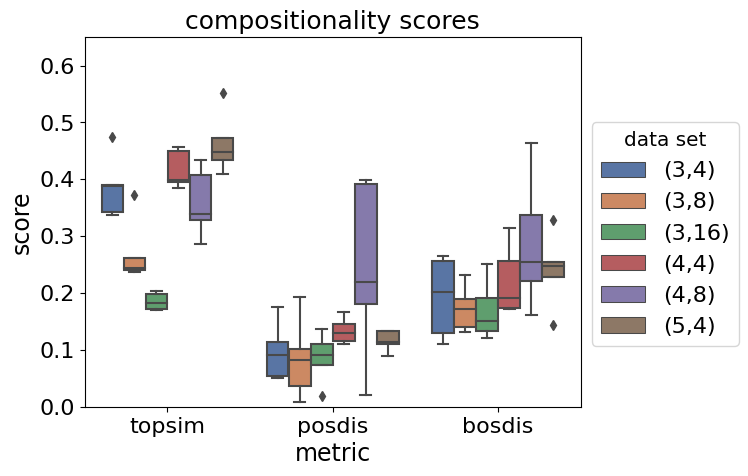

In [40]:
sns.boxplot(x='metric', y='score', data=compositionality_scores[compositionality_scores.data=='all'], 
            hue='dataset', palette='deep')
plt.xlabel(xlabel='metric', fontsize=17)
plt.ylabel(ylabel='score', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=16)
plt.ylim(0, 0.65)
legend = plt.legend(fontsize=16, title='data set', bbox_to_anchor=(1., 0.8))
plt.setp(legend.get_title(),fontsize='x-large')
plt.title('compositionality scores', fontsize=18)
plt.show()

In [ ]:
# Not done (yet)
# compositionality scores for different vocab size factors 

compositionality_scores = {'vs factor':[], 'run':[], 'metric':[], 'score':[]}

for vsf in [1, 2, 3, 4]: 
    for run in range(5):
        
        path = 'results/(4,8)_sample_scaling_10_balanced_False_vsf_' + str(vsf) + '/'
        
        topsim = pickle.load(open(path + 'standard/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent = pickle.load(open(path + 'standard/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        
        for metric in ['topsim', 'posdis', 'bosdis']:
                
                compositionality_scores['vs factor'].append(vsf)
                compositionality_scores['run'].append(run)
                compositionality_scores['metric'].append(metric)

                if metric == 'topsim':
                    compositionality_scores['score'].append(topsim['topsim_train'])
                if metric == 'posdis':
                    compositionality_scores['score'].append(disent['posdis'])
                if metric == 'bosdis':
                    compositionality_scores['score'].append(disent['bosdis'])

compositionality_scores = pd.DataFrame(compositionality_scores)

## co-occurrences

In [ ]:
# Not done (yet)
full_plot = False

fig = plt.figure(figsize=(12,3))

for d, dim in enumerate(datasets): 
    
    data = datasets[d]
    path = paths[d]
    vs_factor = int(path[-2])
    vocab_size = (n_values[d] + 1) * vs_factor + 1
    colors = plt.cm.jet(np.linspace(0,1,vocab_size))
    
    average_cooccurences = []
    
    plt.subplot(1,6,d+1)
    
    for run in range(5):
        
        cooccurences = pickle.load(open(paths[d] + 'standard/' + str(run) + '/normalized_cooccurrence.pkl', 'rb'))
        indices = np.flip(np.argsort(cooccurences[:,-1]))
        cooccurences = cooccurences[indices]
        average_cooccurences.append(cooccurences)
        
    average_cooccurences = np.flip(np.mean(average_cooccurences, axis=0), axis=1)
    
    data_dict = {}
    data_dict['symbol rank'] = []
    data_dict['level'] = []
    data_dict['value'] = []
    for symbol in indices:
        for level in range(average_cooccurences.shape[1]):
            data_dict['symbol rank'].append(symbol+1)
            data_dict['level'].append(level)
            data_dict['value'].append(average_cooccurences[symbol, level])
    
    if full_plot:
        g = sns.heatmap(average_cooccurences, cmap='viridis')
        plt.yticks(ticks=[0.5,vocab_size-1.5], labels=[1,vocab_size], fontsize=14)
    else: 
        g = sns.heatmap(average_cooccurences[0:10,:], cmap='viridis')
        plt.yticks(ticks=[0.5,9.5], labels=[1,10], fontsize=14, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=13)
    for _, spine in g.spines.items():
        spine.set_visible(True)
    #plt.xlabel('# relevant attributes', fontsize=14)
    #plt.ylabel('symbol rank', fontsize=14)
    plt.xticks(ticks=np.arange(n_attributes[d])+0.5, labels=range(1,n_attributes[d]+1), fontsize=14)
    plt.title(data, fontsize=14)
    
    fig.text(0.5, -0.05, '# relevant attributes', ha='center', va='center', fontsize=15, alpha=0.3)
    fig.text(-0.01, 0.5, 'symbol rank', ha='center', va='center', rotation='vertical', fontsize=15, alpha=0.3)

plt.tight_layout()

#### Bootstrapping Confidence Intervals

In [ ]:
# how to bootstrap CIs
from scipy.stats import bootstrap
rng = np.random.default_rng()
from scipy.stats import norm
dist = norm(loc=2, scale=4)  # our "unknown" distribution
data = dist.rvs(size=100, random_state=rng)
print(data)
data = (data,)
print(type(data[0]))
res = bootstrap(data, np.std, confidence_level=0.9, random_state=rng, n_resamples=1000, method='basic')
res